# Visualize specific regions of the disturbance data

In [20]:
import os
import earthpy as et
import json
from os import path
import earthpy.plot as ep
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import rioxarray as rxr
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from tqdm import tqdm
import gc


home = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance")

home_tif = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance", "output_tifs")

forest_folder = path.join(home, "forest-disturbance-stack", "western-conus")

In [21]:
# fire_sum_path = path.join(home, "fire_stack.tif")
# with rio.open(fire_sum_path) as src:
#     print(src.dtypes)
# fire_sum = rxr.open_rasterio(fire_sum_path, masked=True).squeeze()
# fire_int = fire_sum.astype(np.int8)
fire_int_path = path.join(home_tif, 'fire_stack.tif')
# fire_int.rio.to_raster(fire_int_path, dtype=np.int8)
with rio.open(fire_int_path) as src:
    print(src.dtypes)
    crs = src.crs
    bounds = src.bounds

('uint8',)


In [22]:
# beetle_sum_path = path.join(home, "beetle_sum.tif")
# with rio.open(beetle_sum_path) as src:
#     print(src.dtypes)
# beetle_sum = rxr.open_rasterio(beetle_sum_path, masked=True).squeeze()
# beetle_int = beetle_sum.astype(np.int8)
beetle_int_path = path.join(home_tif, 'beetle_stack.tif')
# beetle_int.rio.to_raster(beetle_int_path, dtype=np.int8)
with rio.open(beetle_int_path) as src:
    print(src.dtypes)

('uint8',)


In [23]:
# drought_sum_path = path.join(home, "drought_sum.tif")
# with rio.open(drought_sum_path) as src:
#     print(src.dtypes)
# drought_sum = rxr.open_rasterio(drought_sum_path, masked=True).squeeze()
# drought_int = drought_sum.astype(np.int8)
drought_int_path = path.join(home_tif, 'drought_stack.tif')
# drought_int.rio.to_raster(drought_int_path, dtype=np.int8)
with rio.open(drought_int_path) as src:
    print(src.dtypes)

('uint8',)


In [24]:
epa_ecoregions = gpd.read_file(path.join(home, "EPA-ecoregions", "us_eco_l3", "us_eco_l3.shp")).to_crs(crs)

In [25]:
western_forests_regions = ([str(i) for i in list(range(27))] + 
[str(i) for i in list(range(41, 45))] +
[str(i) for i in list(range(77, 82))] 
)

western_epa = epa_ecoregions[epa_ecoregions['US_L3CODE'].isin(western_forests_regions)]

/home/nathan/miniconda3/envs/earth-analytics-python/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


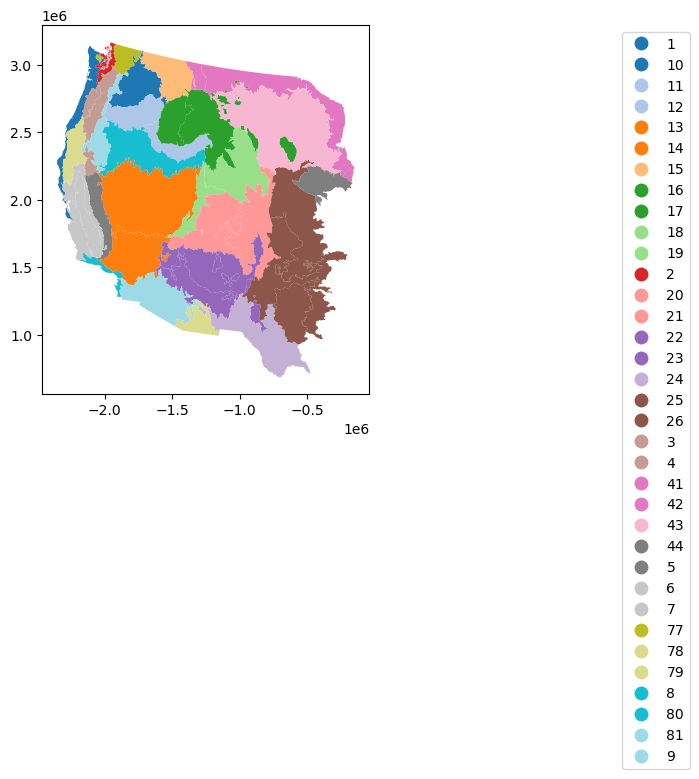

In [26]:
fig, ax = plt.subplots()
western_epa.plot(column='US_L3CODE', legend=True, ax=ax, cmap='tab20')
leg = ax.get_legend()
leg.set_bbox_to_anchor((2, 1))

/home/nathan/miniconda3/envs/earth-analytics-python/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


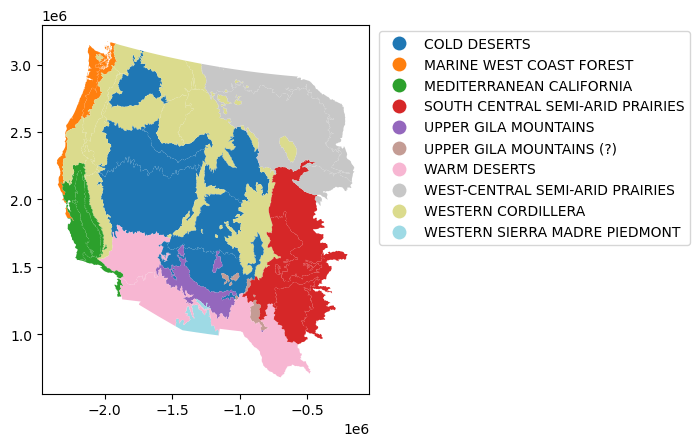

In [27]:
fig, ax = plt.subplots()
western_epa.plot(column='NA_L2NAME', legend=True, ax=ax, cmap='tab20')
leg = ax.get_legend()
leg.set_bbox_to_anchor((2, 1))


In [28]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

cali_region = epa_ecoregions[epa_ecoregions['US_L3CODE'].isin(['5'])]
s_rockies_region = epa_ecoregions[epa_ecoregions['US_L3CODE'].isin(['21'])]
s_rockies_region = s_rockies_region[s_rockies_region.index == 108]
n_rockies_region = epa_ecoregions[epa_ecoregions['US_L3CODE'].isin(['16'])]

cali_features = getFeatures(cali_region)
s_rockies_features = getFeatures(s_rockies_region)
n_rockies_features = getFeatures(n_rockies_region)

s_rockies_bounds = s_rockies_region.total_bounds
s_rockies_extent = (s_rockies_bounds[0], s_rockies_bounds[2], s_rockies_bounds[1], s_rockies_bounds[3])

n_rockies_bounds = n_rockies_region.total_bounds
n_rockies_extent = (n_rockies_bounds[0], n_rockies_bounds[2], n_rockies_bounds[1], n_rockies_bounds[3])

cali_bounds = cali_region.total_bounds
cali_extent = (cali_bounds[0], cali_bounds[2], cali_bounds[1], cali_bounds[3])

In [29]:
# neon_domains = gpd.read_file(path.join(home, "neon-domains", "Polygons-polygon.shp"))
# fig, ax = plt.subplots()
# neon_domains.plot(column="Name", legend=True, ax=ax)
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((2, 1))

In [30]:
# western_forests_domains = ['D12 - Northern Rockies', 
#                            'D13 - Southern Rockies & Colorado Plateau', 
#                            'D14 - Desert Southwest',
#                            'D15 - Great Basin', 
#                            'D16 - Pacific Northwest', 
#                            'D17 - Pacific Southwest']

# western_neon = neon_domains[neon_domains['Name'].isin(western_forests_domains)].clip([-130, 28.97026262, -101.84943552, 50])

# western_neon.plot()

In [31]:
with rio.open(fire_int_path) as src:
    fire_crs = src.crs
    fire_array = src.read(1)
    cali_fire, cali_fire_transform = mask(src, shapes=cali_features, crop=True)
    s_rockies_fire, s_rockies_fire_transform = mask(src, shapes=s_rockies_features, crop=True)
    n_rockies_fire, n_rockies_fire_transform = mask(src, shapes=n_rockies_features, crop=True)
    fire_meta = src.profile
    
cali_fire[cali_fire == 255] = 0
s_rockies_fire[s_rockies_fire == 255] = 0
n_rockies_fire[n_rockies_fire == 255] = 0

In [32]:
with rio.open(drought_int_path) as src:
    drought_array = src.read(1)
    cali_drought, cali_drought_transform = mask(src, shapes=cali_features, crop=True)
    s_rockies_drought, s_rockies_drought_transform = mask(src, shapes=s_rockies_features, crop=True)
    n_rockies_drought, n_rockies_drought_transform = mask(src, shapes=n_rockies_features, crop=True)
    drought_meta = src.profile

cali_drought[cali_drought == 255] = 0
s_rockies_drought[s_rockies_drought == 255] = 0
n_rockies_drought[n_rockies_drought == 255] = 0

In [33]:
with rio.open(beetle_int_path) as src:
    beetle_array = src.read(1)
    s_rockies_beetle, s_rockies_beetle_transform = mask(src, shapes=s_rockies_features, crop=True)
    n_rockies_beetle, n_rockies_beetle_transform = mask(src, shapes=n_rockies_features, crop=True)
    cali_beetle, cali_beetle_transform = mask(src, shapes=cali_features, crop=True)
    beetle_meta = src.profile

cali_beetle[cali_beetle == 255] = 0
s_rockies_beetle[s_rockies_beetle == 255] = 0
n_rockies_beetle[n_rockies_beetle == 255] = 0

In [34]:
with rio.open(beetle_int_path) as src:
    beetle_array = src.read(1)
    s_rockies_beetle, s_rockies_beetle_transform = mask(src, shapes=s_rockies_features, crop=True)
    n_rockies_beetle, n_rockies_beetle_transform = mask(src, shapes=n_rockies_features, crop=True)
    cali_beetle, cali_beetle_transform = mask(src, shapes=cali_features, crop=True)
    beetle_meta = src.profile

cali_beetle[cali_beetle == 255] = 0
s_rockies_beetle[s_rockies_beetle == 255] = 0
n_rockies_beetle[n_rockies_beetle == 255] = 0

In [35]:
all_int_path = path.join(forest_folder, "total_disturbances.tif")
with rio.open(all_int_path) as src:
    all_array = src.read(1)
    s_rockies_all, s_rockies_all_transform = mask(src, shapes=s_rockies_features, crop=True)
    n_rockies_all, n_rockies_all_transform = mask(src, shapes=n_rockies_features, crop=True)
    cali_all, cali_all_transform = mask(src, shapes=cali_features, crop=True)
    all_meta = src.profile
    
cali_all[cali_all == 255] = 0
s_rockies_all[s_rockies_all == 255] = 0
n_rockies_all[n_rockies_all == 255] = 0

In [17]:
YlOrBr = mpl.colormaps['YlOrBr'].resampled(8)
newcolors = YlOrBr(np.linspace(0, 1, 8)) 
white = np.array([0, 0, 0, 0])
newcolors = newcolors[1:, :]
newcolors[:1, :] = white
groups = ["0", "1", "2", "3", "4", "5", "6+"]
classes=[0, 1, 2, 3, 4, 5, 6]
newcmp = ListedColormap(newcolors)

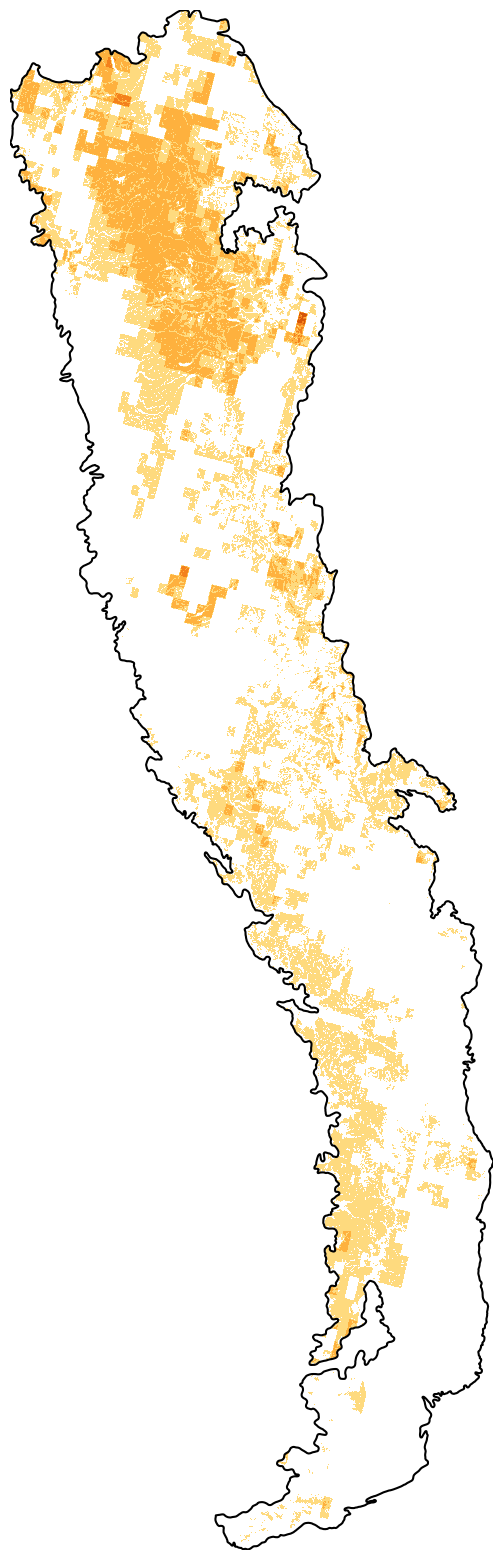

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(cali_drought,
              ax=ax,
              extent=cali_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


cali_region.boundary.plot(ax=ax, color='black')

plt.savefig(path.join(home, "output_images", "cali_drought_image.png"), transparent=True)
plt.show()

KeyboardInterrupt: 

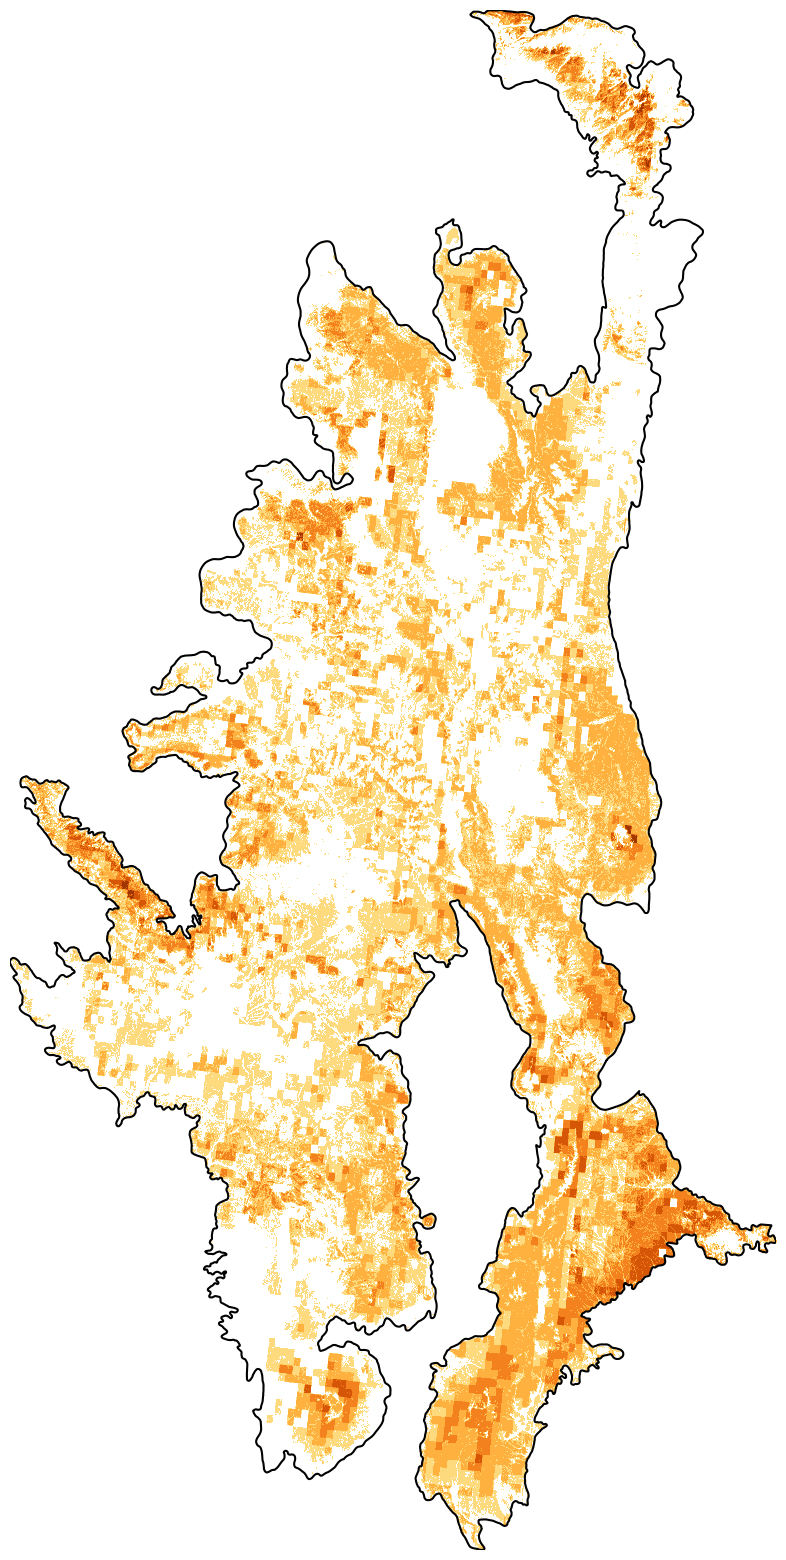

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(s_rockies_drought,
              ax=ax,
              extent=s_rockies_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


s_rockies_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "s_rockies_drought_image.png"), transparent=True)
plt.show()

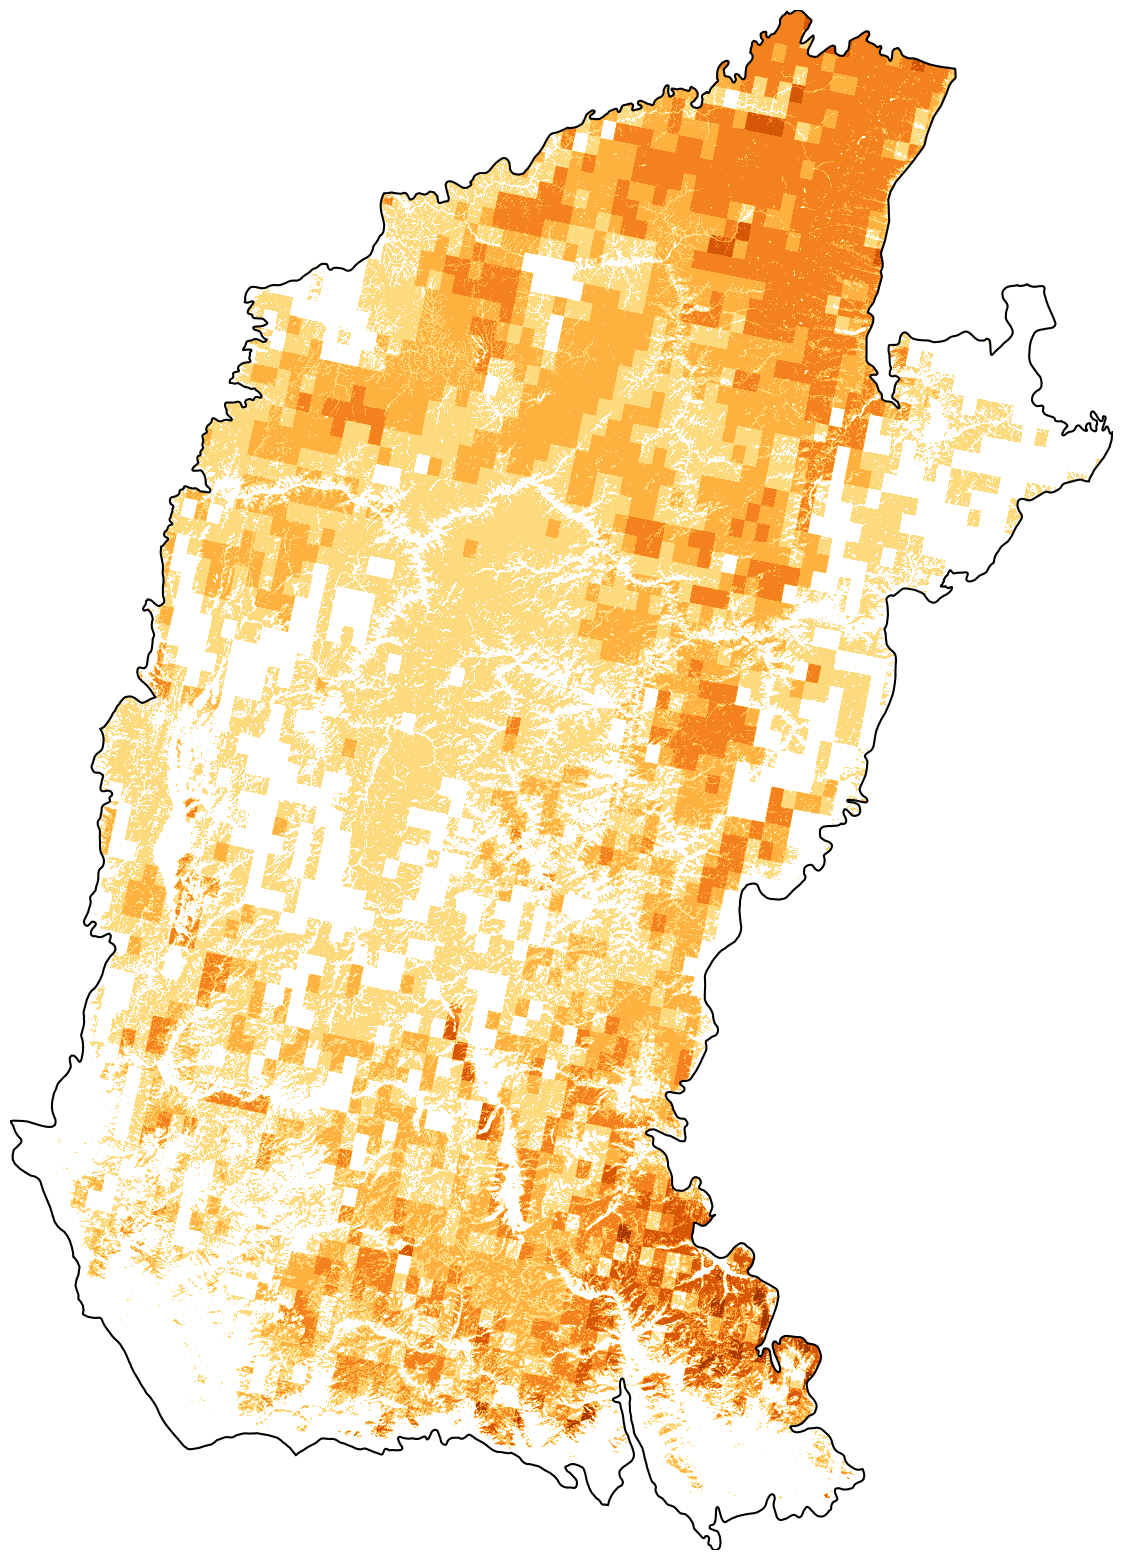

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(n_rockies_drought,
              ax=ax,
              extent=n_rockies_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


n_rockies_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "n_rockies_drought_image.png"), transparent=True)
plt.show()

In [ ]:
YlOrRd = mpl.colormaps['YlOrRd'].resampled(8)
newcolors = YlOrRd(np.linspace(0, 1, 8)) 
white = np.array([0, 0, 0, 0])
newcolors = newcolors[1:, :]
newcolors[:1, :] = white
groups = ["0", "1", "2", "3", "4", "5", "6+"]
classes=[0, 1, 2, 3, 4, 5, 6]
newcmp = ListedColormap(newcolors)

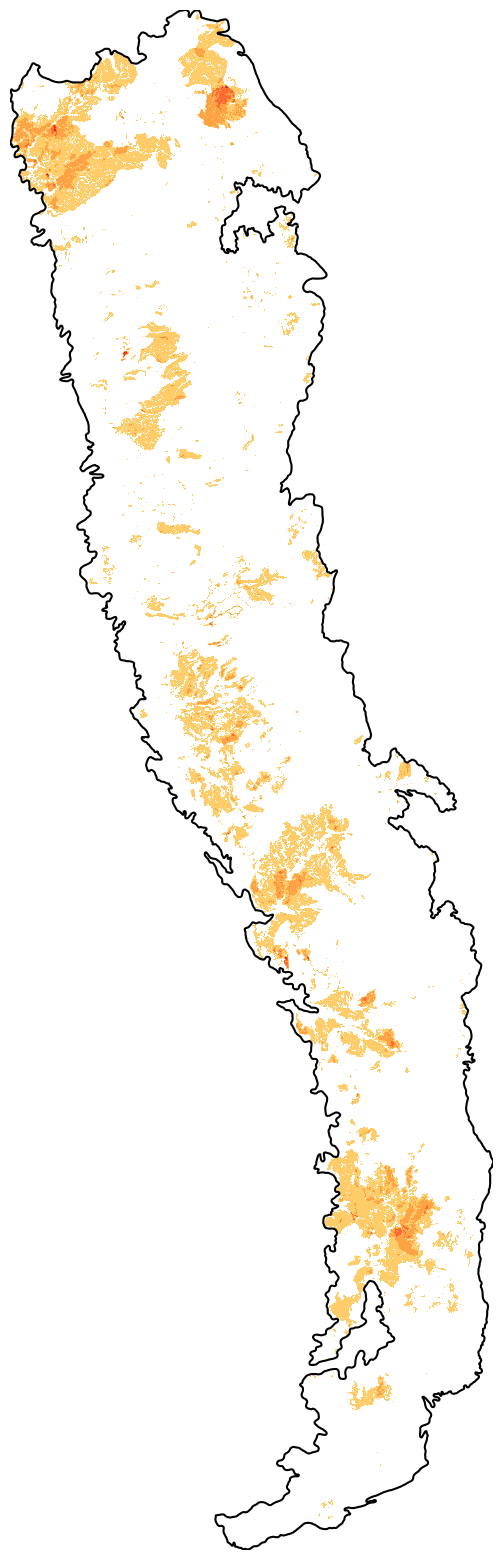

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(cali_fire,
              ax=ax,
              extent=cali_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


cali_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "cali_fire_image.png"), transparent=True)
plt.show()

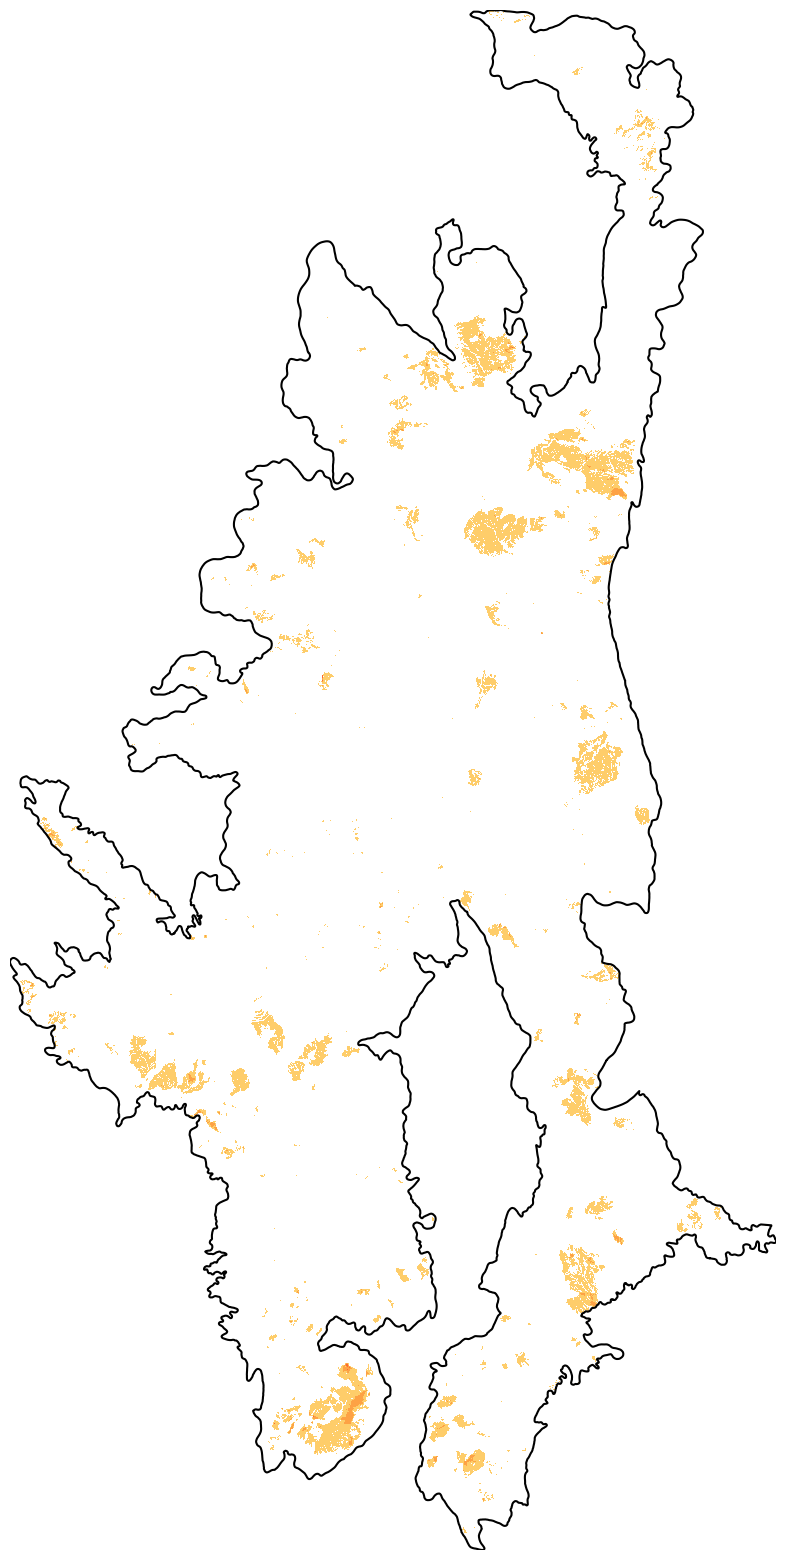

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(s_rockies_fire,
              ax=ax,
              extent=s_rockies_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


s_rockies_region.boundary.plot(ax=ax, color='black')

plt.savefig(path.join(home, "output_images", "s_rockies_fire_image.png"), transparent=True)
plt.show()

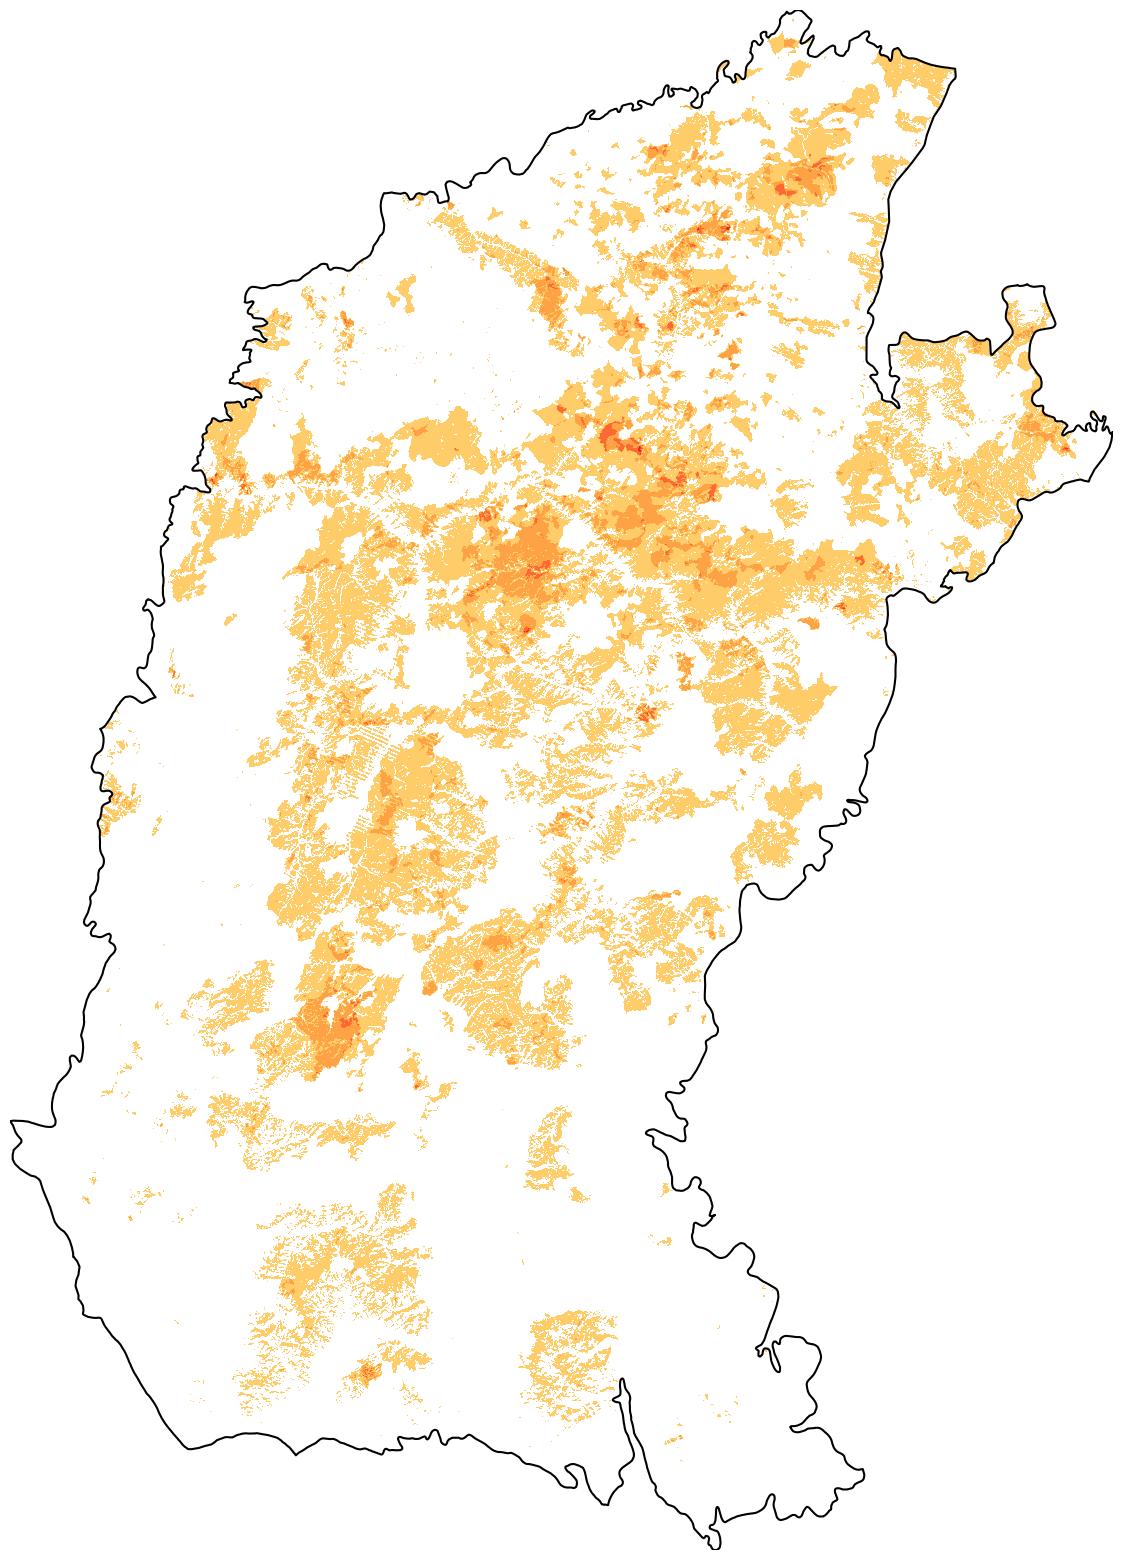

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(n_rockies_fire,
              ax=ax,
              extent=n_rockies_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

n_rockies_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "n_rockies_fire_image.png"), transparent=True)
plt.show()

In [ ]:
greens = mpl.colormaps['viridis'].resampled(10)
newcolors = greens(np.linspace(0, 1, 10)) 
white = np.array([0, 0, 0, 0])
newcolors = newcolors[3:, :]
newcolors[:1, :] = white
groups = ["0", "1", "2", "3", "4", "5", "6+"]
classes=[0, 1, 2, 3, 4, 5, 6]
newcmp = ListedColormap(newcolors)

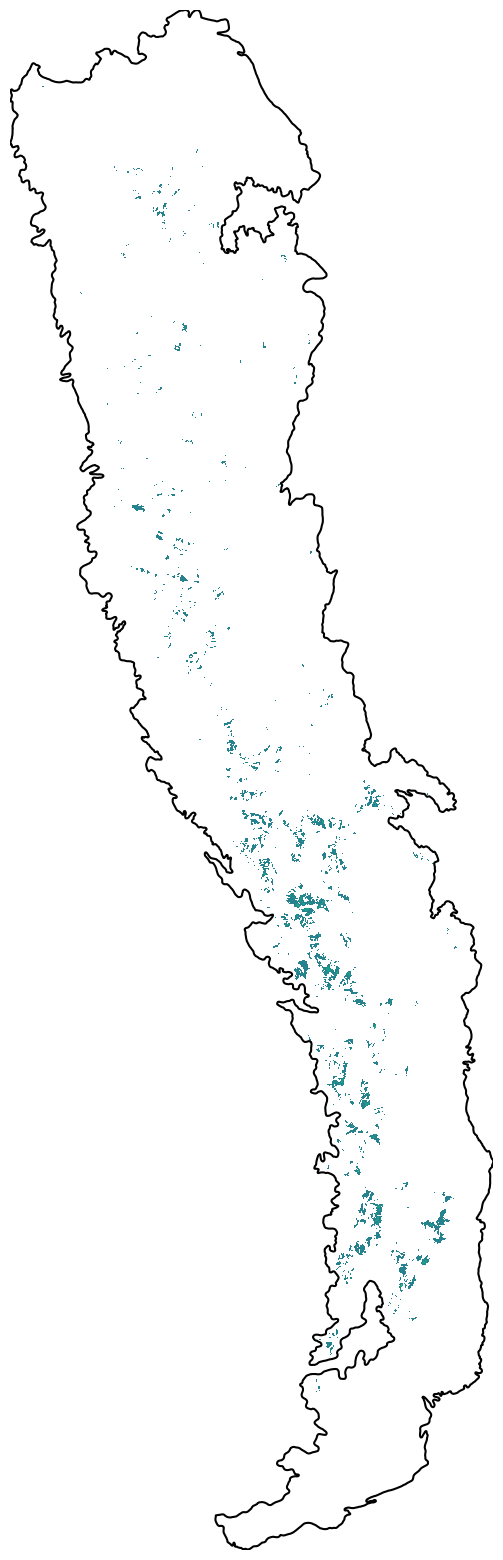

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(cali_beetle,
              ax=ax,
              extent=cali_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


cali_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "cali_beetle_image.png"), transparent=True)
plt.show()

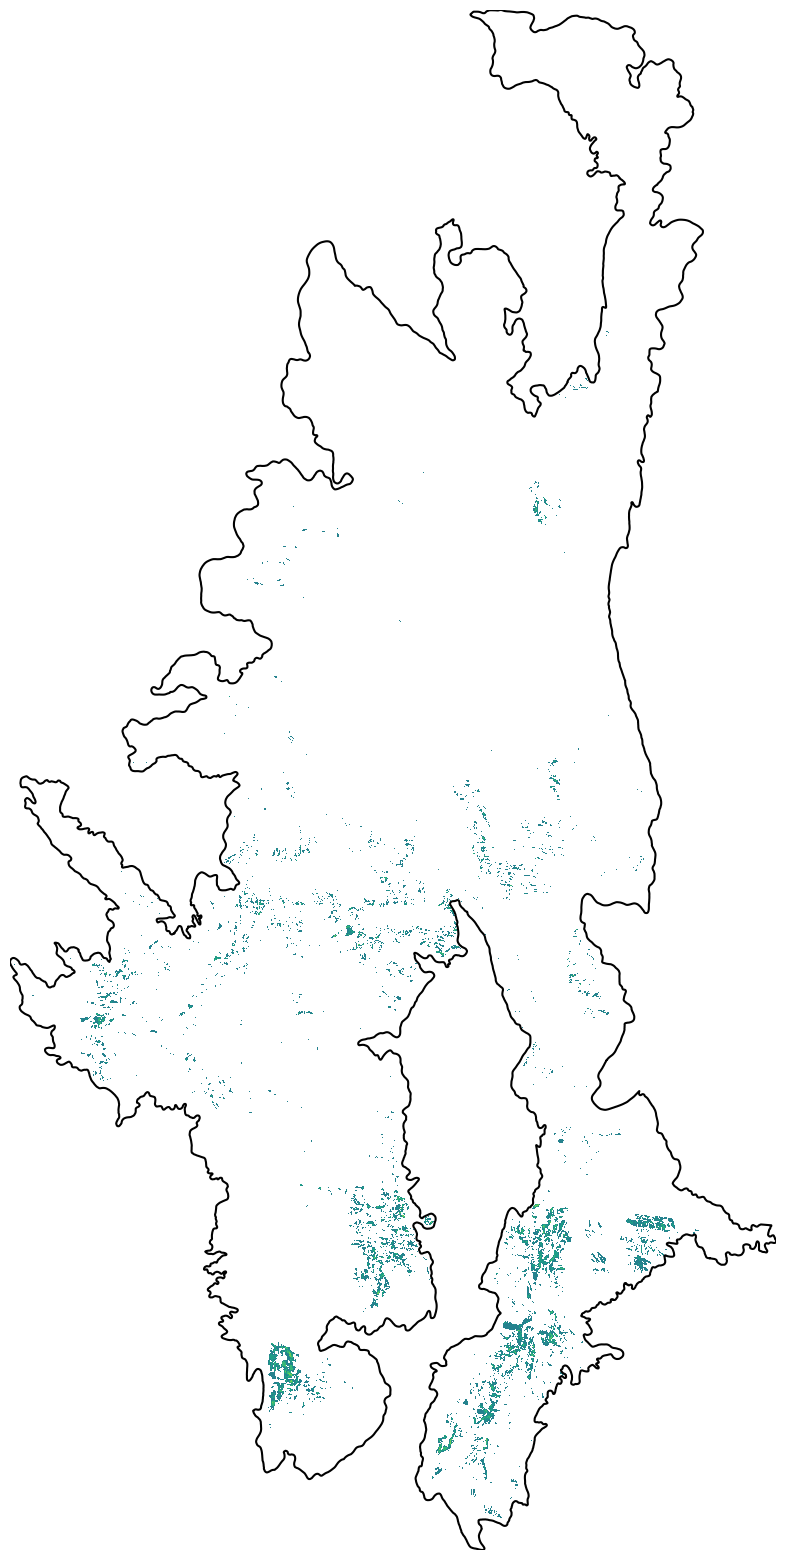

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(s_rockies_beetle,
              ax=ax,
              extent=s_rockies_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


s_rockies_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "s_rockies_beetle_image.png"), transparent=True)
plt.show()

NameError: name 'newcmp' is not defined

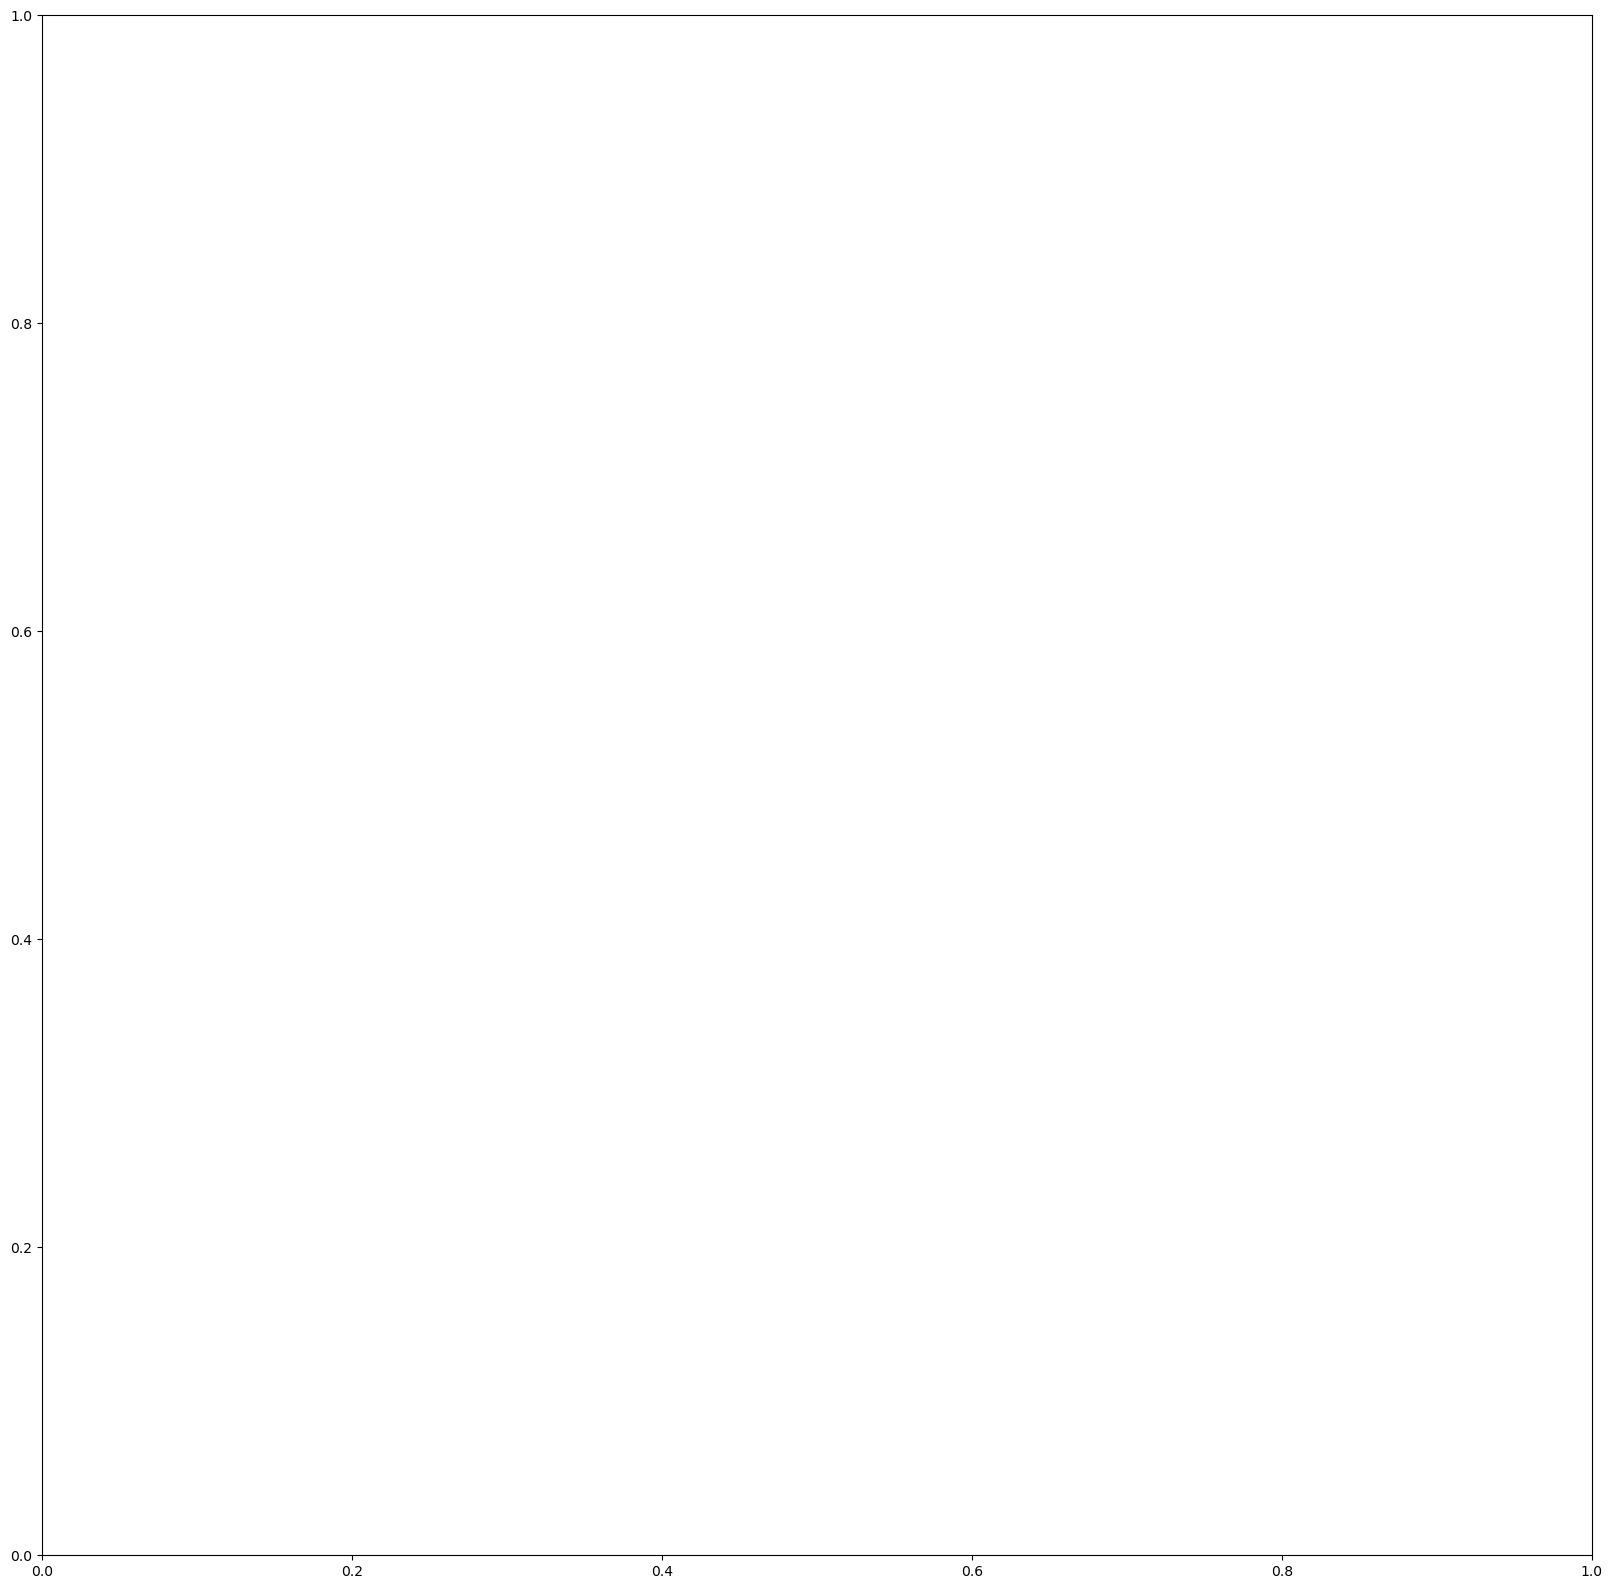

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(n_rockies_beetle,
              ax=ax,
              extent=n_rockies_extent, 
              cmap=newcmp, 
              vmax=6,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


n_rockies_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "n_rockies_beetle_image.png"), transparent=True)
plt.show()

In [36]:
RdPu = mpl.colormaps['RdPu'].resampled(50)
newcolors = RdPu(np.linspace(0, 1, 50)) 
white = np.array([0, 0, 0, 0])
newcolors[:1, :] = white
groups = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12+"]
classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
newcmp = ListedColormap(newcolors)

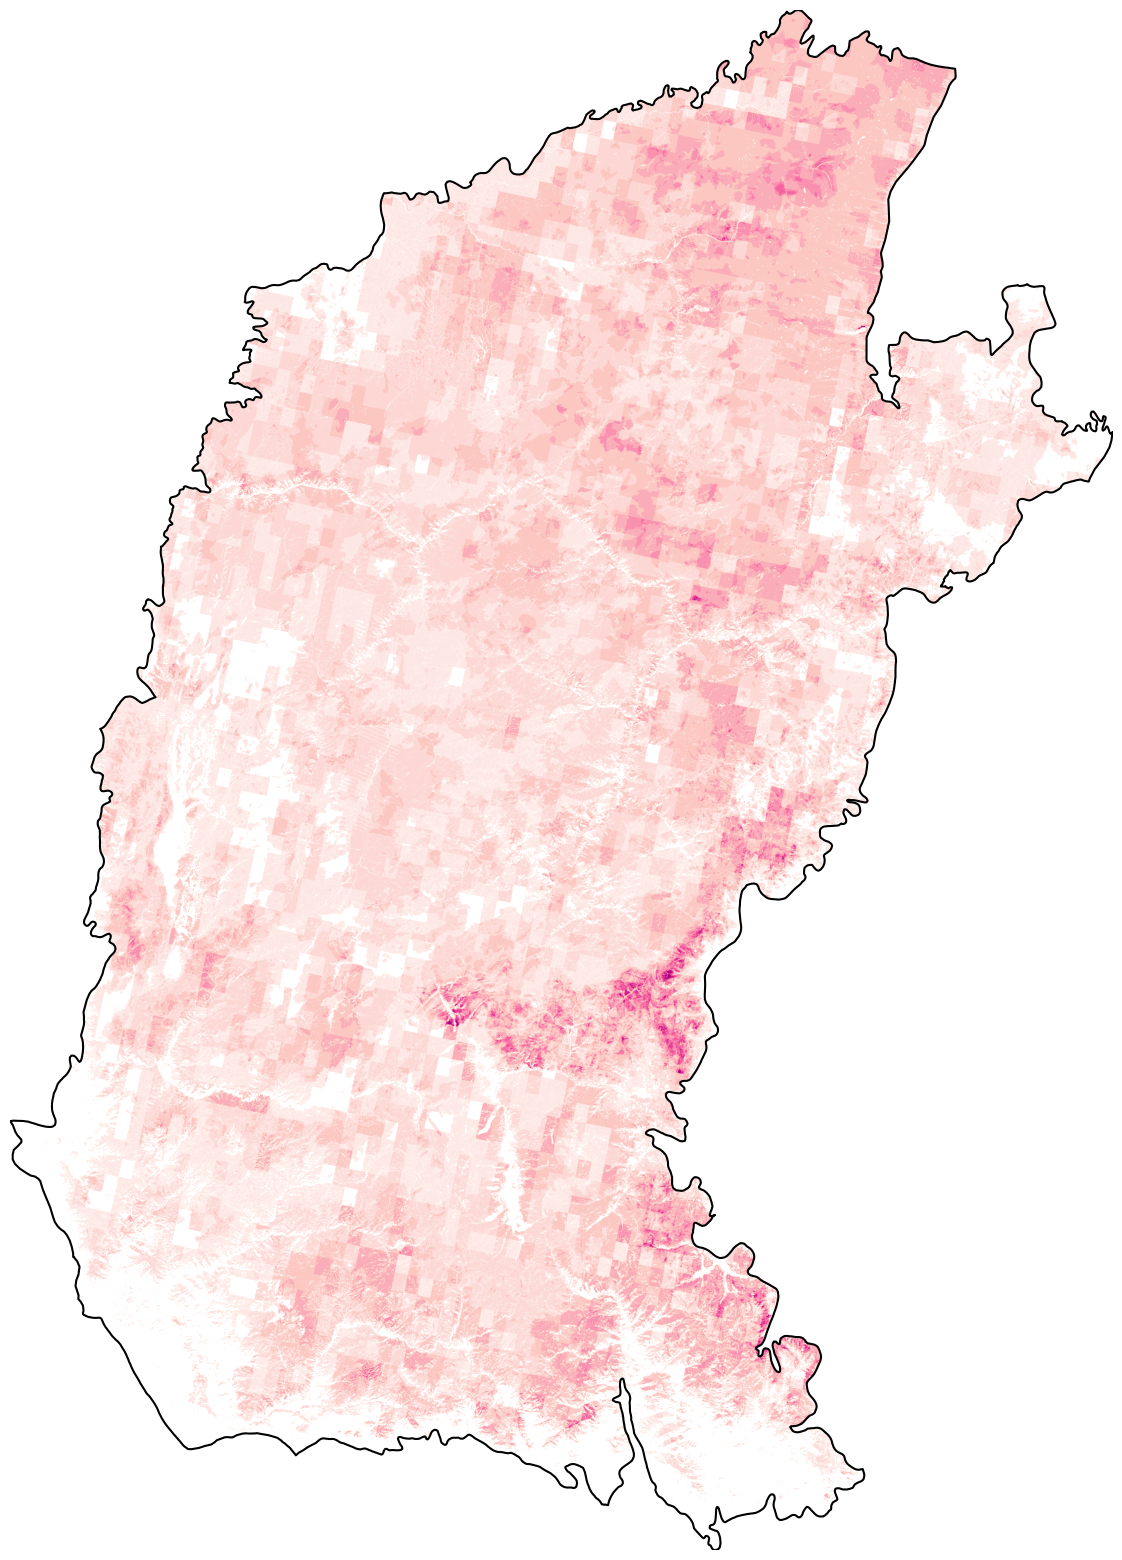

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(n_rockies_all,
              ax=ax,
              extent=n_rockies_extent, 
              cmap=newcmp, 
              vmax=12,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


n_rockies_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "n_rockies_all_image.png"), transparent=True)
plt.show()

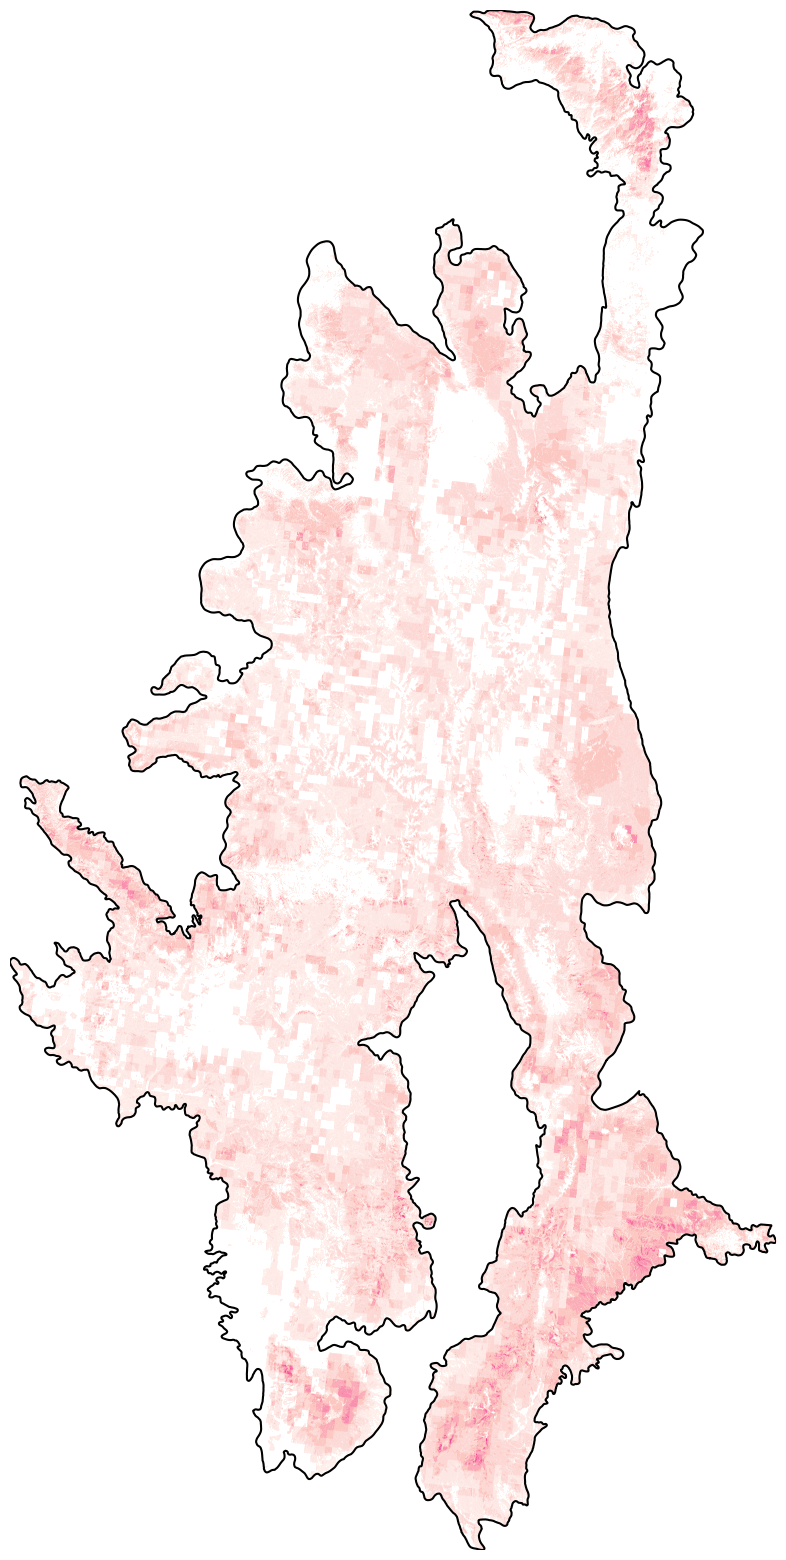

In [38]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(s_rockies_all,
              ax=ax,
              extent=s_rockies_extent, 
              cmap=newcmp, 
              vmax=12,
              cbar=False,
              scale=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


s_rockies_region.boundary.plot(ax=ax, color="black")

plt.savefig(path.join(home, "output_images", "s_rockies_all_image.png"), transparent=True)
plt.show()